# ENTRENANDO AL MODELO

### Configuración del Entorno y Librerías

In [1]:
from pathlib import Path  # Manejo de rutas

import joblib  # Machine Learning
import matplotlib.pyplot as plt
import pandas as pd  # Manipulación de datos
import seaborn as sns  # Estilizar gráficas
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report)
from sklearn.model_selection import train_test_split

### Constantes Globales y Configuración

In [11]:
RANDOM_STATE = 42  # Semilla Inicial

# Se define y se crea el directorio dónde se guardarán los modelos.
MODEL_DIR = Path("model")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Se configura la estética de las gráficas que se generarán.
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

### Carga de datos

In [12]:
DATA_FILE = Path("../data/processed/entrenamiento.csv")  # Definición de la ruta
df = pd.DataFrame()  # Inicialización del DataFrame

try:
    df = pd.read_csv(DATA_FILE)  # Carga del dataset
    print(f"Dataset cargado. Dimensiones: {df.shape}")  # Confirmación de la carga

    # Se muestran las primeras filas y el resumen de tipos de datos para asegurarse de que los datos leídos son correctos.
    display(df.head())  # Se usa display para mostrar de una mejor forma el dataset
    print("\nInformación - Dataset")
    df.info()

except FileNotFoundError:
    print(f"Error: No se encontró el archivo en {DATA_FILE.resolve()}")  # Validación en caso de no existir/encontrar el archivo.


Información - Dataset
<class 'pandas.DataFrame'>
RangeIndex: 3630 entries, 0 to 3629
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Modo_solicitud                 3630 non-null   int64  
 1   Orden_solicitud                3630 non-null   int64  
 2   Carrera                        3630 non-null   int64  
 3   Asistencia_diurna_nocturna     3630 non-null   int64  
 4   Calificacion_previa            3630 non-null   int64  
 5   Calificacion_madre             3630 non-null   int64  
 6   Calificacion_padre             3630 non-null   int64  
 7   Ocupacion_madre                3630 non-null   int64  
 8   Ocupacion_padre                3630 non-null   int64  
 9   Desplazado                     3630 non-null   int64  
 10  Deudor                         3630 non-null   int64  
 11  Pagos_al_dia                   3630 non-null   int64  
 12  Genero                         3630 

### Asignación de variables

In [13]:
TARGET_COL = 'Es_Desertor'  # Se guarda en una constante que buscamos

# (Matriz X) y la variable a predecir (y).
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Se muestran las dimensiones resultantes.
print(f"Dimensiones -> Features (X): {X.shape}, Target (y): {y.shape}")

# Se verifica la proporción de clases para detectar si el dataset está desbalanceado antes de entrenar.
print("\nDistribución de la variable objetivo")
display(y.value_counts(normalize=True).rename("Proporción"))

Es_Desertor
0    0.60854
1    0.39146
Name: Proporción, dtype: float64

### Regla Pareto

In [14]:
# Se aplica la regla de Pareto usando la semilla global para asegurar que la división sea idéntica en cada ejecución.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# Se imprimen las dimensiones de los conjuntos resultantes para verificar la división 80/20.
print(f"Set de Entrenamiento: {X_train.shape[0]} muestras")
print(f"Set de Prueba:         {X_test.shape[0]} muestras")

# Finalmente, se verifica que la estratificación funcionó comparando proporciones.
print("\nVerificación de Estratificación (Proporción de Clases)")
print(f"Original:  {y.mean():.2%}")
print(f"Train:     {y_train.mean():.2%}")
print(f"Test:      {y_test.mean():.2%}")

Set de Entrenamiento: 2904 muestras
Set de Prueba:         726 muestras

Verificación de Estratificación (Proporción de Clases)
Original:  39.15%
Train:     39.15%
Test:      39.12%


### Entrenamiento del Modelo

In [15]:
import multiprocessing  # Para usar todos los núcleos disponibles

# Se detecta el número de núcleos disponibles en el procesador.
n_cores = multiprocessing.cpu_count()
print(f"Hardware Detectado: {n_cores} núcleos de CPU.")

# Configura el clasificador Random Forest.
# - n_jobs=-1: Ordena usar TODOS los núcleos disponibles (Paralelismo).
# - verbose=1: Muestra logs del proceso de entrenamiento para ver el avance.
modelo = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=1)

# Entrenamiento
print(f"Entrenamiento Iniciado ({n_cores} hilos usados)")
modelo.fit(X_train, y_train)

# Guardar el modelo entrenado
output_path = MODEL_DIR / "modelo_random_forest.pkl"
joblib.dump(modelo, output_path)

print(f"Modelo entrenado y guardado en: {output_path}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished


### Predicciones

In [16]:
# Se usa el conjunto de prueba (X_test) para generar predicciones con el modelo entrenado.
y_pred = modelo.predict(X_test)

# Visualización en una matriz de confusión
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.grid(False)
plt.title("Matriz de Confusión: Desempeño del Modelo")
plt.show()

# Métricas Detalladas
raw_report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(raw_report).transpose()

# Aquí se definieron diccionarios de mapeo para traducir las métricas técnicas al español.
column_translation = {
    "precision": "Precisión",
    "recall": "Sensibilidad (Recall)",
    "f1-score": "F1-Score",
    "support": "Muestras (Soporte)"
}

index_translation = {
    "accuracy": "Exactitud Global (Accuracy)",
    "macro avg": "Promedio Macro",
    "weighted avg": "Promedio Ponderado"
}

# Aplica la traducción a las columnas e índices.
df_report.rename(columns=column_translation, index=index_translation, inplace=True)

# Se muestra el reporte
print("\nReporte de Clasificación Detallado")
display(df_report.style.format("{:.2f}"))  # Formatea números a 2 decimales.

,Precisión,Sensibilidad (Recall),F1-Score,Muestras (Soporte)
0,0.92,0.95,0.94,442.00
1,0.92,0.87,0.90,284.00
Exactitud Global (Accuracy),0.92,0.92,0.92,0.92
Promedio Macro,0.92,0.91,0.92,726.00
Promedio Ponderado,0.92,0.92,0.92,726.00


### Testeo del Modelo

- Configuración

In [17]:
MODEL_PATH = Path(str(MODEL_DIR) + "/modelo_random_forest.pkl")


# Se carga el modelo entrenado
def cargar_modelo(ruta):
    if not ruta.exists():
        raise FileNotFoundError(f"No se encontró el modelo en: {ruta}")
    return joblib.load(ruta)


# Genera un gráfico para visualizar elementos importantes
def visualizar_importancia(model, top_n=10):
    importancias = model.feature_importances_
    nombres = model.feature_names_in_

    # Crea un DataFrame y lo ordena para visualizarlo mejor.
    df_imp = pd.DataFrame({'Feature': nombres, 'Importancia': importancias})
    df_imp = df_imp.sort_values('Importancia', ascending=False).head(top_n)

    # Configura y muestra el gráfico.
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_imp, x='Importancia', y='Feature', hue='Feature', palette='viridis', legend=False)
    plt.title(f"Top {top_n} Variables que Definen la Deserción")
    plt.xlabel("Peso en la decisión del modelo")
    plt.ylabel("Variable")
    plt.tight_layout()
    plt.show()


# Realiza la predicción y guarda los resultados
def predecir_estudiante(model, datos_estudiante):
    df_nuevo = pd.DataFrame([datos_estudiante])
    df_nuevo = df_nuevo[model.feature_names_in_]

    # Obtiene la clase predicha (0 o 1) y las probabilidades exactas.
    prediccion = model.predict(df_nuevo)[0]
    probabilidad = model.predict_proba(df_nuevo)[0]  # [Prob_No, Prob_Si]

    # Formatea la salida para el usuario.
    estado = "DESERTOR" if prediccion == 1 else "NO DESERTOR"
    riesgo = probabilidad[1] * 100

    print(f"\nResultado del Diagnóstico")
    print(f"Predicción: Estudiante {estado}")
    print(f"Nivel de Riesgo (Probabilidad de deserción): {riesgo:.2f}%")
    print(f"Probabilidad de retención: {probabilidad[0] * 100:.2f}%")

- Ejecución Principal

In [21]:
# Se define un caso de prueba
caso_riesgo_alto = {
    'Modo_solicitud': 1, 'Orden_solicitud': 2, 'Carrera': 1,
    'Asistencia_diurna_nocturna': 0, 'Calificacion_previa': 0,
    'Calificacion_madre': 9, 'Calificacion_padre': 8,
    'Ocupacion_madre': 4, 'Ocupacion_padre': 4,
    'Desplazado': 1, 'Deudor': 1, 'Pagos_al_dia': 0,
    'Genero': 1, 'Becado': 0, 'Edad_al_matricularse': 24,
    'Unidades_1er_sem_matriculadas': 6, 'Unidades_1er_sem_evaluaciones': 4,
    'Unidades_1er_sem_aprobadas': 2, 'Unidades_1er_sem_nota': 8.5,
    'Unidades_2do_sem_matriculadas': 6, 'Unidades_2do_sem_evaluaciones': 3,
    'Unidades_2do_sem_aprobadas': 1, 'Unidades_2do_sem_nota': 7.8,
    'Tasa_desempleo': 11.5, 'Tasa_inflacion': 2.1, 'PIB': 1.10
}

# Se carga el modelo y ejecuta la predicción.
try:
    modelo = cargar_modelo(MODEL_PATH)
    predecir_estudiante(modelo, caso_riesgo_alto)

except Exception as e:
    print(f"Ocurrió un error en el flujo de inferencia: {e}")

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 100 out of 100 | elapsed:    0.0s finished


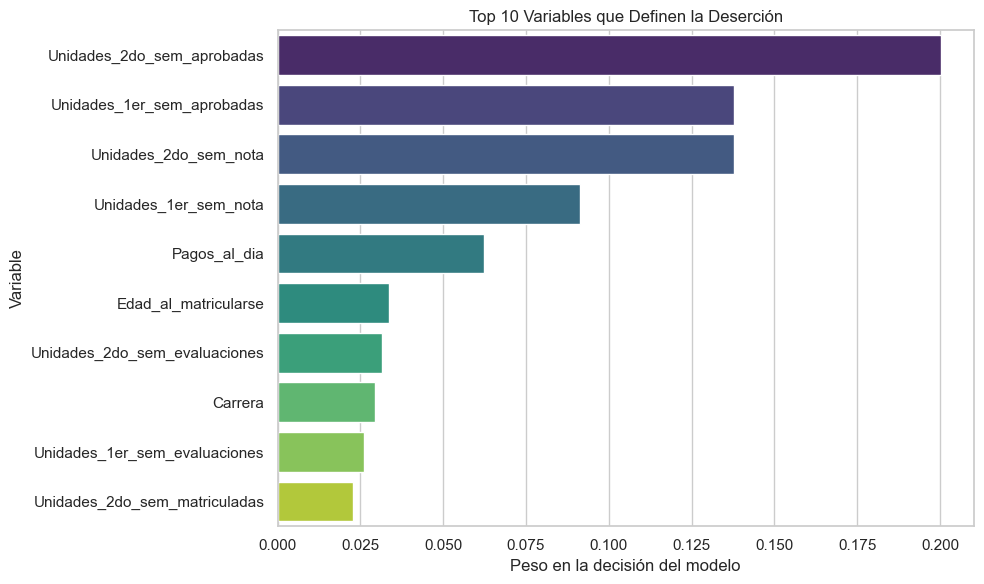

In [22]:
visualizar_importancia(modelo)  # Se muestra que variables tuvieron más inferencia.